<a href="https://colab.research.google.com/github/ayatbahaa96/stock-price-prediction/blob/main/LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=3d06ef495e9135b2a827d44b2b80f917adf566b6ba6019f70308d7b2a7354b00
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [4]:
def fetch_stock_data(ticker, start='2020-01-01', end='2024-01-01'):
    """ Fetch stock data from Yahoo Finance and rename columns properly """
    df = yf.download(ticker, start=start, end=end)

    # Expected column names (may vary)
    expected_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

    # If 'Adj Close' exists, include it; otherwise, ignore it
    if 'Adj Close' in df.columns:
        expected_columns.append('Adj Close')

    # Rename the columns dynamically
    df.columns = expected_columns

    # Reset index so 'Date' is a normal column
    df.reset_index(inplace=True)

    print(df.head())  # Display first few rows for verification
    return df

# Fetch stock data
df = fetch_stock_data('AAPL')


[*********************100%***********************]  1 of 1 completed

        Date       Open       High        Low      Close     Volume
0 2020-01-02  72.796005  72.856598  71.545372  71.799858  135480400
1 2020-01-03  72.088280  72.851746  71.862877  72.020416  146322800
2 2020-01-06  72.662712  72.701492  70.954002  71.206070  118387200
3 2020-01-07  72.320984  72.929329  72.100426  72.672417  108872000
4 2020-01-08  73.484352  73.787315  72.022858  72.022858  132079200


In [5]:
df

,Date,Open,High,Low,Close,Volume
0,2020-01-02,72.796005,72.856598,71.545372,71.799858,135480400
1,2020-01-03,72.088280,72.851746,71.862877,72.020416,146322800
2,2020-01-06,72.662712,72.701492,70.954002,71.206070,118387200
3,2020-01-07,72.320984,72.929329,72.100426,72.672417,108872000
4,2020-01-08,73.484352,73.787315,72.022858,72.022858,132079200
...,...,...,...,...,...,...
1001,2023-12-22,192.656174,194.457347,192.029240,194.228458,37122800
1002,2023-12-26,192.108856,192.944757,191.889928,192.666124,28919300
1003,2023-12-27,192.208374,192.556674,190.158419,191.551603,48087700
1004,2023-12-28,192.636292,193.711028,192.228287,193.193559,34049900


In [6]:
def add_technical_indicators(df):
    """ Add technical indicators and ensure they return single Series (not DataFrames) """

    # Relative Strength Index (RSI)
    rsi = ta.momentum.RSIIndicator(df['Close'])
    df['RSI'] = rsi.rsi()

    # Moving Average Convergence Divergence (MACD)
    macd = ta.trend.MACD(df['Close'])
    df['MACD'] = macd.macd()  # Extract the MACD line only

    # Bollinger Bands
    bb = ta.volatility.BollingerBands(df['Close'])
    df['BB_High'] = bb.bollinger_hband()  # Upper Bollinger Band
    df['BB_Low'] = bb.bollinger_lband()   # Lower Bollinger Band

    # Simple Moving Averages (SMA)
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()

    # Ensure no NaN values exist
    df.dropna(inplace=True)

    # Display first few rows to verify correctness
    print(df[['RSI', 'MACD', 'BB_High', 'BB_Low', 'SMA_50', 'SMA_200']].head())

    return df

# Apply the function
df = add_technical_indicators(df)


           RSI      MACD     BB_High      BB_Low      SMA_50    SMA_200
199  53.008176  1.384519  121.184187  102.117821  114.377135  86.153572
200  55.715676  1.560774  121.970954  102.393129  114.593331  86.386523
201  53.988384  1.578288  121.758560  104.110777  114.725212  86.611928
202  49.299886  1.281228  121.827934  104.385015  114.795496  86.823053
203  49.885732  1.070487  121.867958  104.837957  114.887256  87.029140


In [12]:
def prepare_data(df):
    df = df[['Close', 'RSI', 'MACD', 'BB_High', 'BB_Low', 'SMA_50', 'SMA_200']]

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    X, y = [], []
    for i in range(60, len(scaled_data)):  # Using 60 days of past data
        X.append(scaled_data[i-60:i])
        y.append(scaled_data[i, 0])  # Predicting 'Close' price

    X, y = np.array(X), np.array(y)
    print(f"Training data shape: {X.shape}, Labels shape: {y.shape}")

    return train_test_split(X, y, test_size=0.2, random_state=42), scaler

# Prepare data
(X_train, X_test, y_train, y_test), scaler = prepare_data(df)


Training data shape: (747, 60, 7), Labels shape: (747,)


In [13]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = build_lstm_model((X_train.shape[1], X_train.shape[2]))

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - loss: 0.0883 - val_loss: 0.0090
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0156 - val_loss: 0.0062
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0101 - val_loss: 0.0040
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0077 - val_loss: 0.0043
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0080 - val_loss: 0.0032
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0071 - val_loss: 0.0047
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.0068 - val_loss: 0.0029
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0049 - val_loss: 0.0029
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0050 - val_loss: 0.0027
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0055 - val_loss: 0.0026
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0047 - val_loss: 0.0026
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0

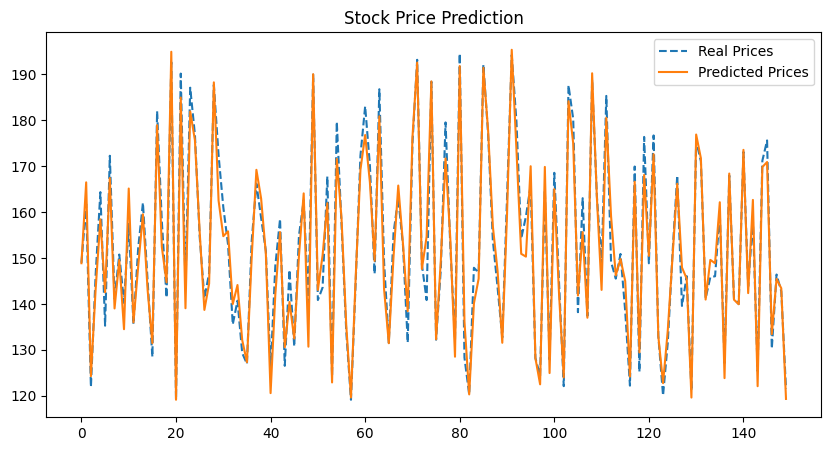

In [15]:
# Ensure correct shape for inverse transformation
predictions = predictions.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Get the correct number of features used in scaling
num_features = X_train.shape[2]  # Number of features used in training (7)

# Create a placeholder array of zeros with the correct number of features
zeros_placeholder = np.zeros((predictions.shape[0], num_features - 1))

# Concatenate predictions with zeros to match original feature count
predictions_full = np.hstack((predictions, zeros_placeholder))
y_test_full = np.hstack((y_test, zeros_placeholder))

# Apply inverse transformation
predictions = scaler.inverse_transform(predictions_full)[:, 0]
y_test = scaler.inverse_transform(y_test_full)[:, 0]

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Real Prices', linestyle='dashed')
plt.plot(predictions, label='Predicted Prices')
plt.legend()
plt.title("Stock Price Prediction")
plt.show()


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(y_test, predictions))
mape = mean_absolute_percentage_error(y_test, predictions) * 100  # Convert to percentage
print('Evaluation of LSTM model')
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")


Evaluation of LSTM model
RMSE: 4.139141771213938
MAPE: 2.1245892267274207%
